In [0]:
from lxml import etree
from multiprocessing import Pool, cpu_count
import time

import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import cv2

In [2]:
!wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
!wget "https://www.biography.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cg_face%2Cq_auto:good%2Cw_300/MTIzNjEzMTg5MzA5MzY3ODIy/benedict_cumberbatchjpg.jpg"
!mv "benedict_cumberbatchjpg.jpg" "photo.jpg"

--2020-05-28 08:11:40--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.1s    

2020-05-28 08:11:41 (7.10 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2020-05-28 08:11:44--  https://www.biography.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cg_face%2Cq_auto:good%2Cw_300/MTIzNjEzMTg5MzA5MzY3ODIy/benedict_cumberbatchjpg.jpg
Resolving www.biography.com (www.biography.com)... 151.101.130.98, 151.101.194.98, 151.101.2.98, ...
Connecting to www.biography.com (www.biography.com)|151.101.130.98|:4

In [0]:
cascade_path = "haarcascade_frontalface_default.xml"

with open(cascade_path) as f:
    xml = f.read()

In [0]:
root = etree.fromstring(xml)

cascade = root.find("cascade")
width = int(cascade.find("width").text)
height = int(cascade.find("height").text)
features = cascade.find("features").getchildren()

In [0]:
feature_matrices = np.zeros((len(features), height, width))
for i, feature in enumerate(features):
    cur_matrix = np.zeros((height, width))
    for rect in feature.find("rects").getchildren():
        line = rect.text.strip().split(" ")
        x1, y1, x2, y2 = map(int, line[:4])
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)
        c = float(line[4])
        
        cur_matrix[y1:y2+1, x1:x2+1] = c
    
    feature_matrices[i] = cur_matrix

In [0]:
stages = cascade.find("stages")
stages_list = []
for stage in stages.getchildren():
    if type(stage) == etree._Element:
        threshold = float(stage.find("stageThreshold").text)
        clfs = stage.find("weakClassifiers")
        
        classifiers = []
        for clf in clfs:
            internal_nodes = clf.find("internalNodes").text.strip().split(" ")
            feature_num = int(internal_nodes[2])
            feature_thresh = float(internal_nodes[3])
            
            leafs = clf.find("leafValues").text.strip().split(" ")
            less_leaf = float(leafs[0])
            greater_leaf = float(leafs[1])
            
            classifiers.append([feature_num, feature_thresh, less_leaf, greater_leaf])
        
        stages_list.append([threshold, classifiers])

In [7]:
len(stages_list)

25

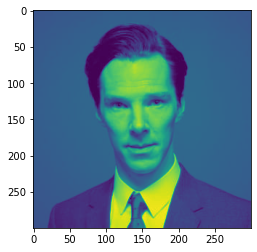

In [8]:
image = cv2.imread("photo.jpg", 0)
image_height, image_width = image.shape[:2]
plt.imshow(image)

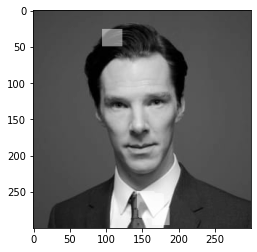

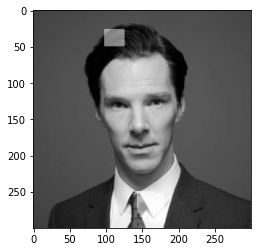

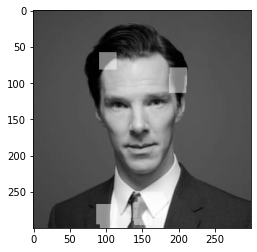

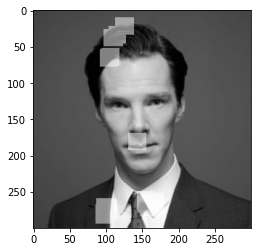

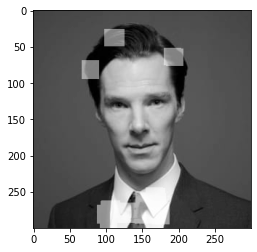

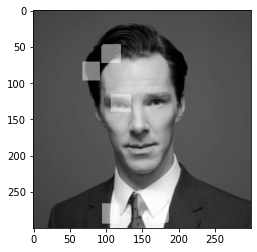

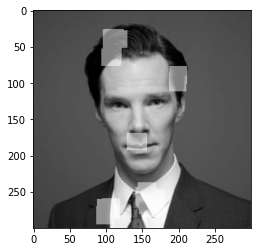

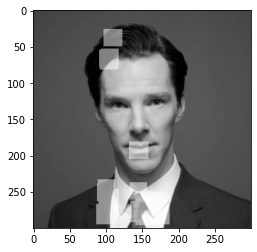

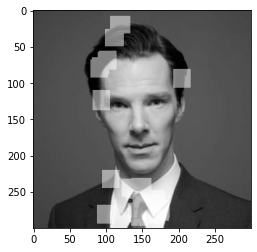

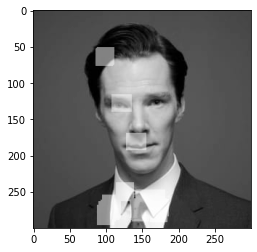

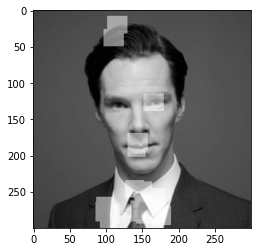

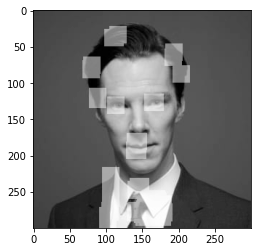

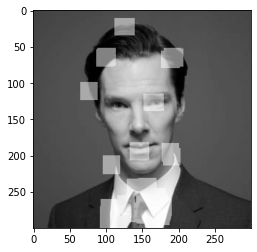

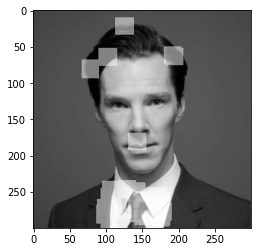

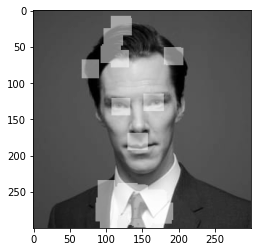

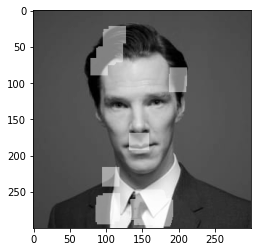

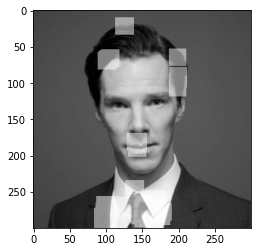

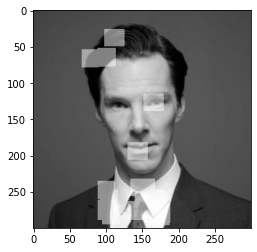

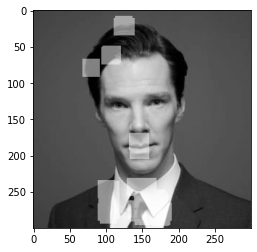

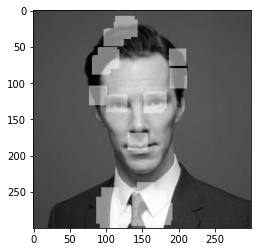

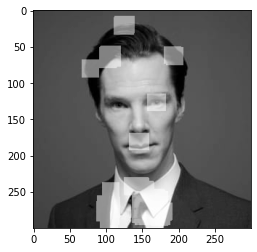

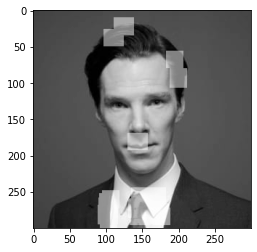

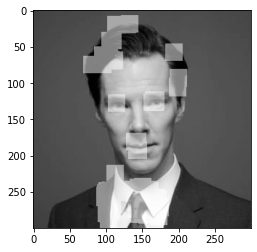

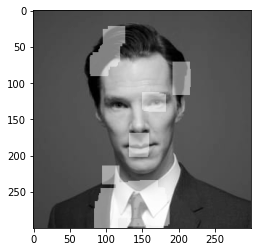

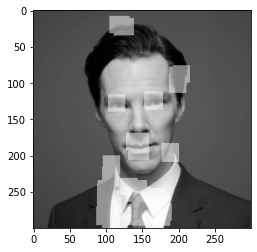

In [9]:
for stage in stages_list:
    image_copy = image.copy()
    
    for classifier in stage[1]:
        feature_num, thresh, less, greater = classifier
        
        activation_map = convolve2d(image, feature_matrices[feature_num], mode="valid")
        
        if greater > less:
            activation_map[activation_map < thresh] = 0
        else:
            activation_map[activation_map > thresh] = 0
        
        # top 5 non-zero activations
        k = 5
        flatten_activation_map = activation_map.flatten()
        top_indices = np.argpartition(flatten_activation_map, -k)[-k:]

        # filter zero activations
        top_indices = top_indices[flatten_activation_map[top_indices] > 0]
        
        for top_index in top_indices:
            i, j = np.unravel_index(top_index, activation_map.shape)

            image_part = image[i:i+height, j:j+width].astype(np.uint8)
            rectangle = np.ones(image_part.shape, dtype=np.uint8) * 255
            
            res = cv2.addWeighted(image_part, 0.5, rectangle, 0.5, 1.0)
            image_copy[i:i+height, j:j+width] = res
    
    plt.figure()
    plt.imshow(image_copy, cmap="gray")
    plt.show()

In [0]:
def get_top_classifier_outputs(image, feature, thresh, less, greater, k=5):
    activation_map = convolve2d(image, feature, mode="valid")
    if greater > less:
        activation_map[activation_map < thresh] = 0
    else:
        activation_map[activation_map > thresh] = 0
    
    # top k non-zero activations
    flatten_activation_map = activation_map.flatten()
    top_indices = np.argpartition(flatten_activation_map, -k)[-k:]

    # filter zero activations
    top_indices = top_indices[flatten_activation_map[top_indices] > 0]
    
    return top_indices

In [0]:
def get_stage_images(image, stages_list, feature_matrices, height, width):
    result_images = []

    for stage in stages_list:
        args = []
        for classifier in stage[1]:
            feature_num, thresh, less, greater = classifier
            arg = [image, feature_matrices[feature_num], thresh, less, greater]
            args.append(arg)
        
        with Pool(cpu_count()) as pool:
            map_res = pool.starmap(get_top_classifier_outputs, args)

            white_area = np.zeros(image.shape, dtype=np.uint8)

            activation_shape = list(image.shape)
            activation_shape[0] -= height - 1
            activation_shape[1] -= width - 1

            for top_indices in map_res:
                for top_index in top_indices:
                    i, j = np.unravel_index(top_index, activation_shape)
                    white_area[i:i+height, j:j+width] = 255
            
            result_image = cv2.addWeighted(image, 0.5, white_area, 0.5, 1.0)
    
        result_images.append(result_image)
    return result_images

In [0]:
scale = 1.1

In [13]:
scale_times = 3

marked_images = []
for i in range(scale_times):
    new_image_height = int(image_height / scale ** i)
    new_image_width = int(image_width / scale ** i)

    image_scaled = cv2.resize(image, (new_image_width, new_image_height),
                       interpolation=cv2.INTER_NEAREST)
    

    t0 = time.time()
    marked_images.append(get_stage_images(image_scaled, stages_list,
                                          feature_matrices, height, width))
    t1 = time.time()
    print("scale", scale ** i, "took", t1-t0, "s")

scale 1.0 took 371.0280730724335 s
scale 1.1 took 308.2254319190979 s
scale 1.2100000000000002 took 249.47119784355164 s


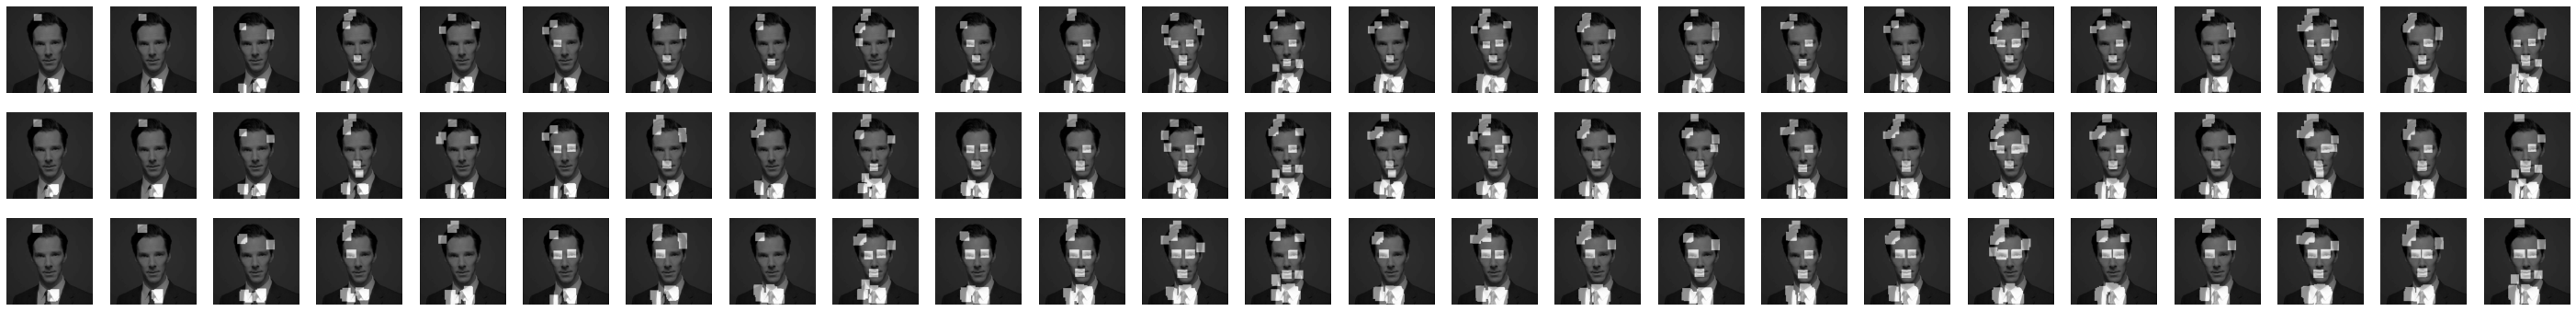

In [14]:
fig, axes = plt.subplots(scale_times, len(stages_list), figsize=(50, 6))
for i in range(scale_times):
    for j in range(len(stages_list)):
        axes[i][j].axis("off")
        axes[i][j].imshow(marked_images[i][j], cmap="gray")